# Drug Classification - Decision Tree and Random Forest

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from mlxtend.evaluate import bootstrap_point632_score
from sklearn import tree

## Import Dataset

In [2]:
df = pd.read_csv("drug200.csv")
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


## Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [4]:
df = df.rename(columns = lambda x: x.lower().strip().replace("na_to_k", "Na/K"))

In [5]:
df.loc[:, "drug"].value_counts(), df.loc[:,"bp"].value_counts(), df.loc[:,"cholesterol"].value_counts() 

(drug
 drugY    91
 drugX    54
 drugA    23
 drugC    16
 drugB    16
 Name: count, dtype: int64,
 bp
 HIGH      77
 LOW       64
 NORMAL    59
 Name: count, dtype: int64,
 cholesterol
 HIGH      103
 NORMAL     97
 Name: count, dtype: int64)

## Visual Dataset

<Axes: xlabel='drug', ylabel='count'>

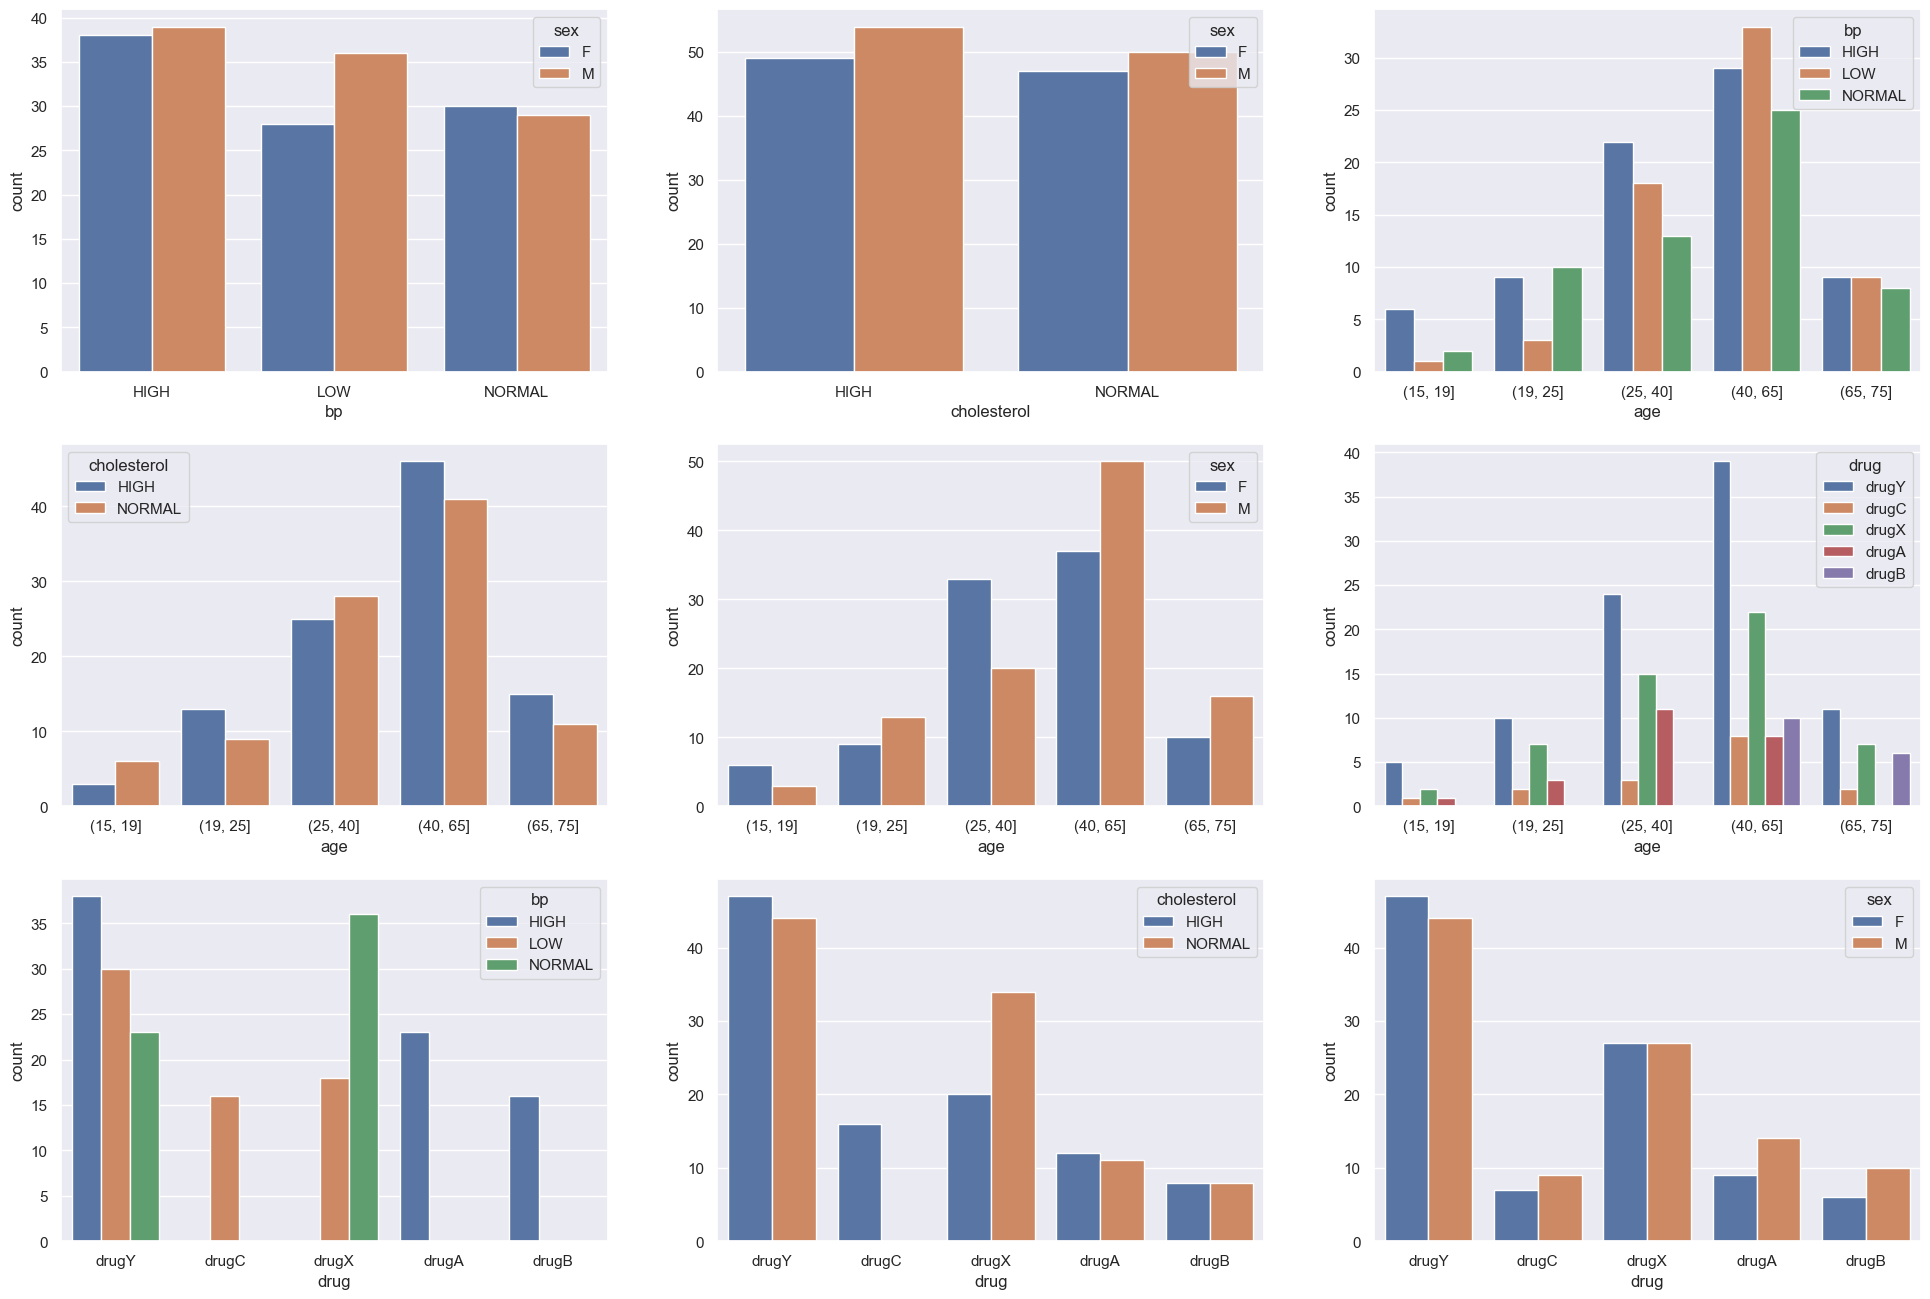

In [6]:
_, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (24, 16))

sns.countplot(data = df, x = 'bp', hue = 'sex', ax = axes[0][0])
sns.countplot(data = df, x = 'cholesterol', hue = 'sex', ax = axes[0][1])
sns.countplot(data = df, x = pd.cut(df.loc[:, "age"], [15, 19, 25, 40, 65, 75]), hue = 'bp', ax = axes[0][2])
sns.countplot(data = df, x = pd.cut(df.loc[:, "age"], [15, 19, 25, 40, 65, 75]), hue = 'cholesterol', ax = axes[1][0])
sns.countplot(data = df, x = pd.cut(df.loc[:, "age"], [15, 19, 25, 40, 65, 75]), hue = 'sex', ax = axes[1][1])
sns.countplot(data = df, x = pd.cut(df.loc[:, "age"], [15, 19, 25, 40, 65, 75]), hue = 'drug', ax = axes[1][2])
sns.countplot(data = df, x = 'drug', hue = 'bp', ax = axes[2][0])
sns.countplot(data = df, x = 'drug', hue = 'cholesterol', ax = axes[2][1])
sns.countplot(data = df, x = 'drug', hue = 'sex', ax = axes[2][2])

<Axes: xlabel='age', ylabel='Density'>

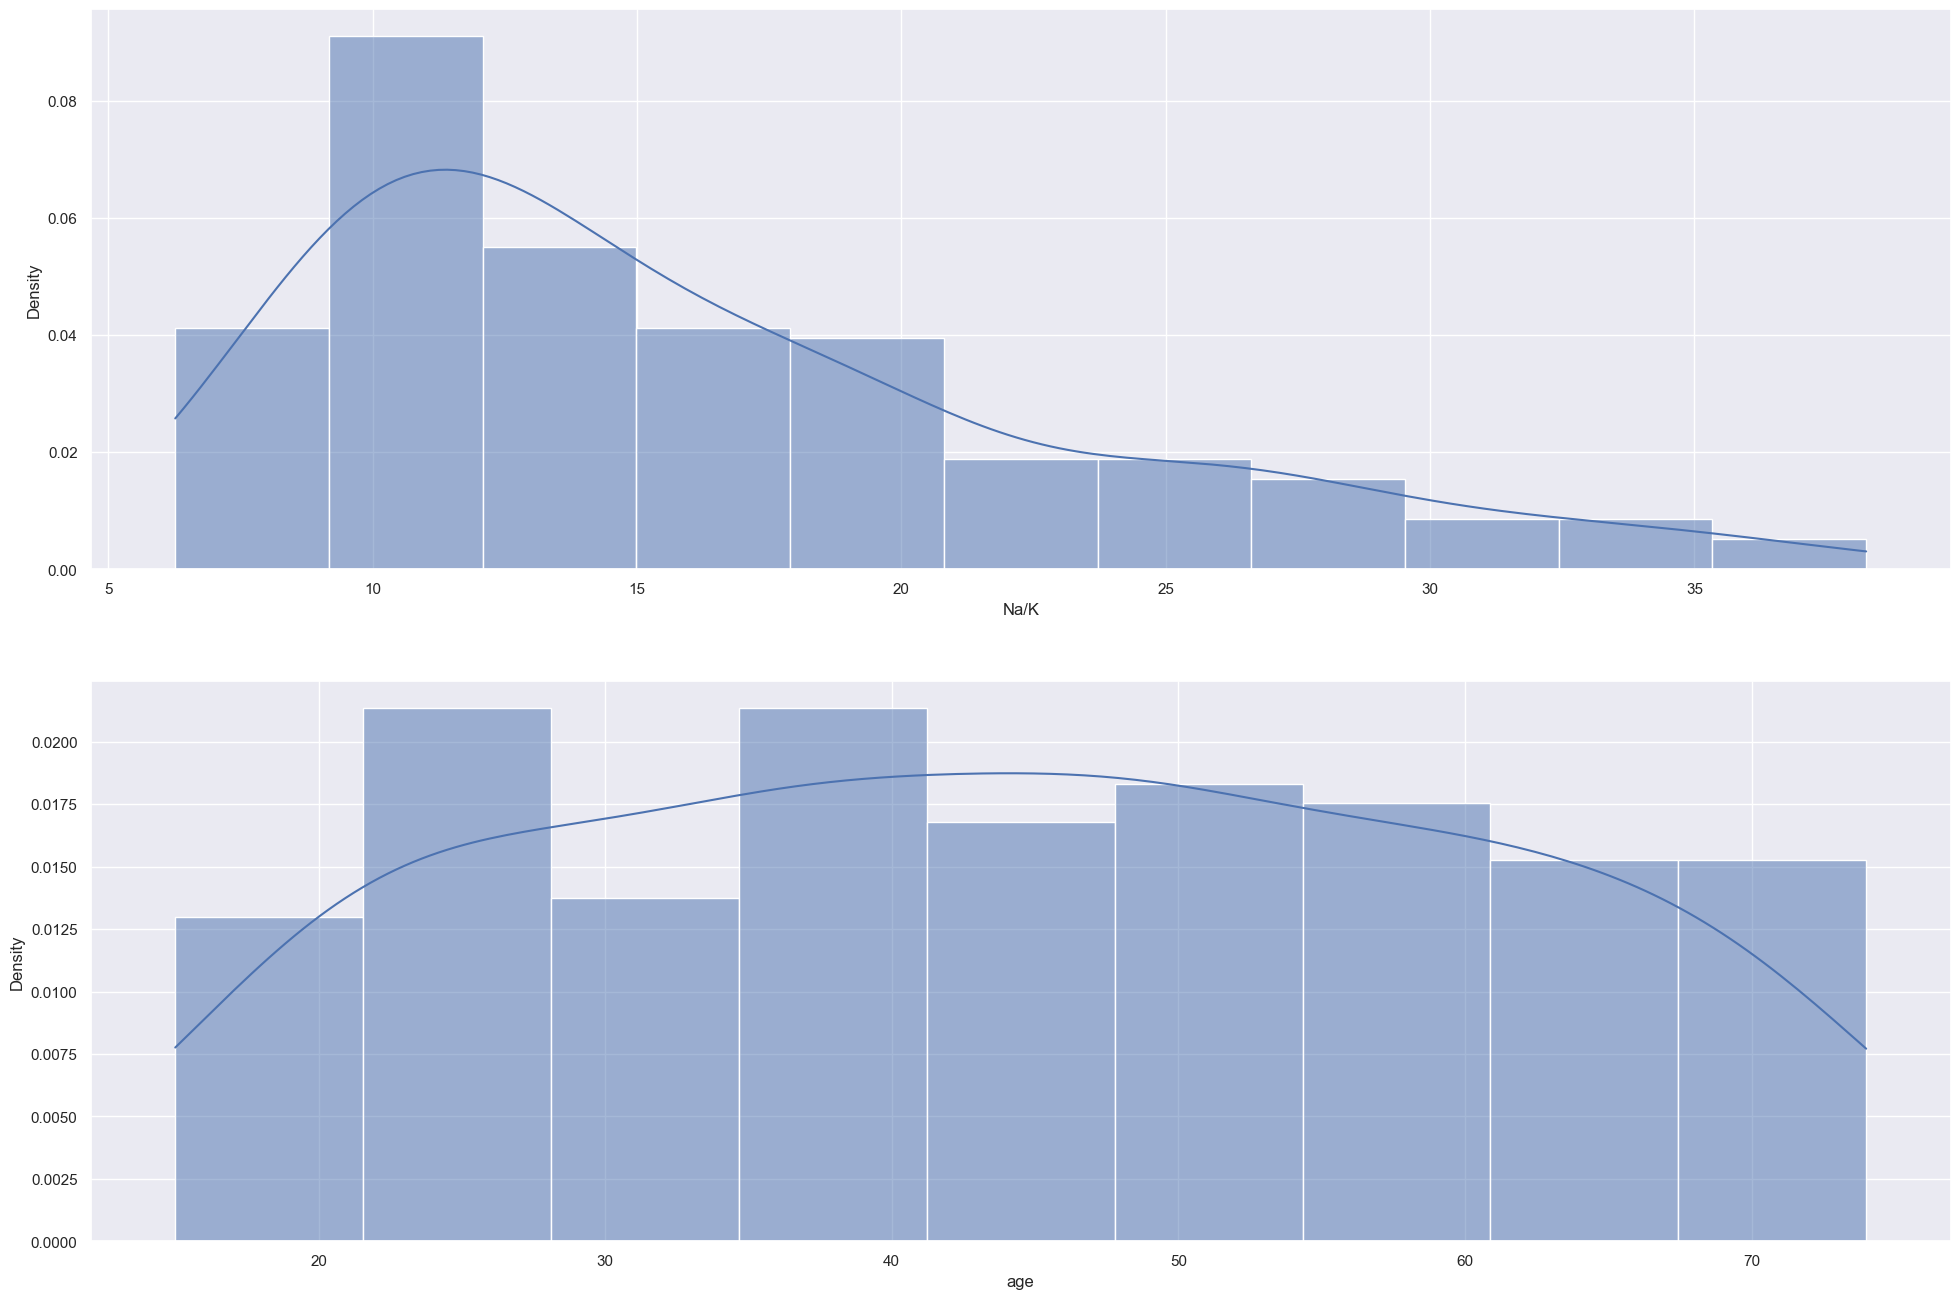

In [7]:
_, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (24, 16))

sns.histplot(df["Na/K"], kde=True, stat="density", ax = axes[0])
sns.histplot(df["age"], kde=True, stat="density", ax = axes[1])

## Data Preparation

In [8]:
le = LabelEncoder()
df['drug'] = le.fit_transform(df['drug']) # use a label encoder to map the labels from categorical to nominal
df['sex'] = df['sex'].map({"F": 0, "M": 1}).astype(np.int32) # manually map the sex feature from categorical to nominal
df['cholesterol'] = df['cholesterol'].map({"NORMAL": 2, "HIGH": 5}).astype(np.int32) # manually map the cholesterol feature from categorical to ordinal
df['bp'] = df['bp'].map({"LOW": 0, "NORMAL": 2, "HIGH": 5}).astype(np.int32) # manually map the bp feature from categorical to ordinal

In [9]:
df.head()

,age,sex,bp,cholesterol,Na/K,drug
0,23,0,5,5,25.355,4
1,47,1,0,5,13.093,2
2,47,1,0,5,10.114,2
3,28,0,2,5,7.798,3
4,61,0,0,5,18.043,4


In [10]:
# Let's seperate the features and the labels into two numpy arrays: X(feautres) and y(labels)

X = df.loc[:, "age":"Na/K"].values
y = df.loc[:, 'drug'].values

In [11]:
print(f"Feature array shape:{X.shape}")
print(f"Target array size: {y.size}")

Feature array shape:(200, 5)
Target array size: 200


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 123,
                                                    stratify = y,
                                                    shuffle = True)
print(f"Train features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Train labels shape: {y_train.size}")
print(f"Test labels shape: {y_test.size}")

Train features shape: (160, 5)
Test features shape: (40, 5)
Train labels shape: 160
Test labels shape: 40


[Text(0.5, 0, 'Test Set Na/K')]

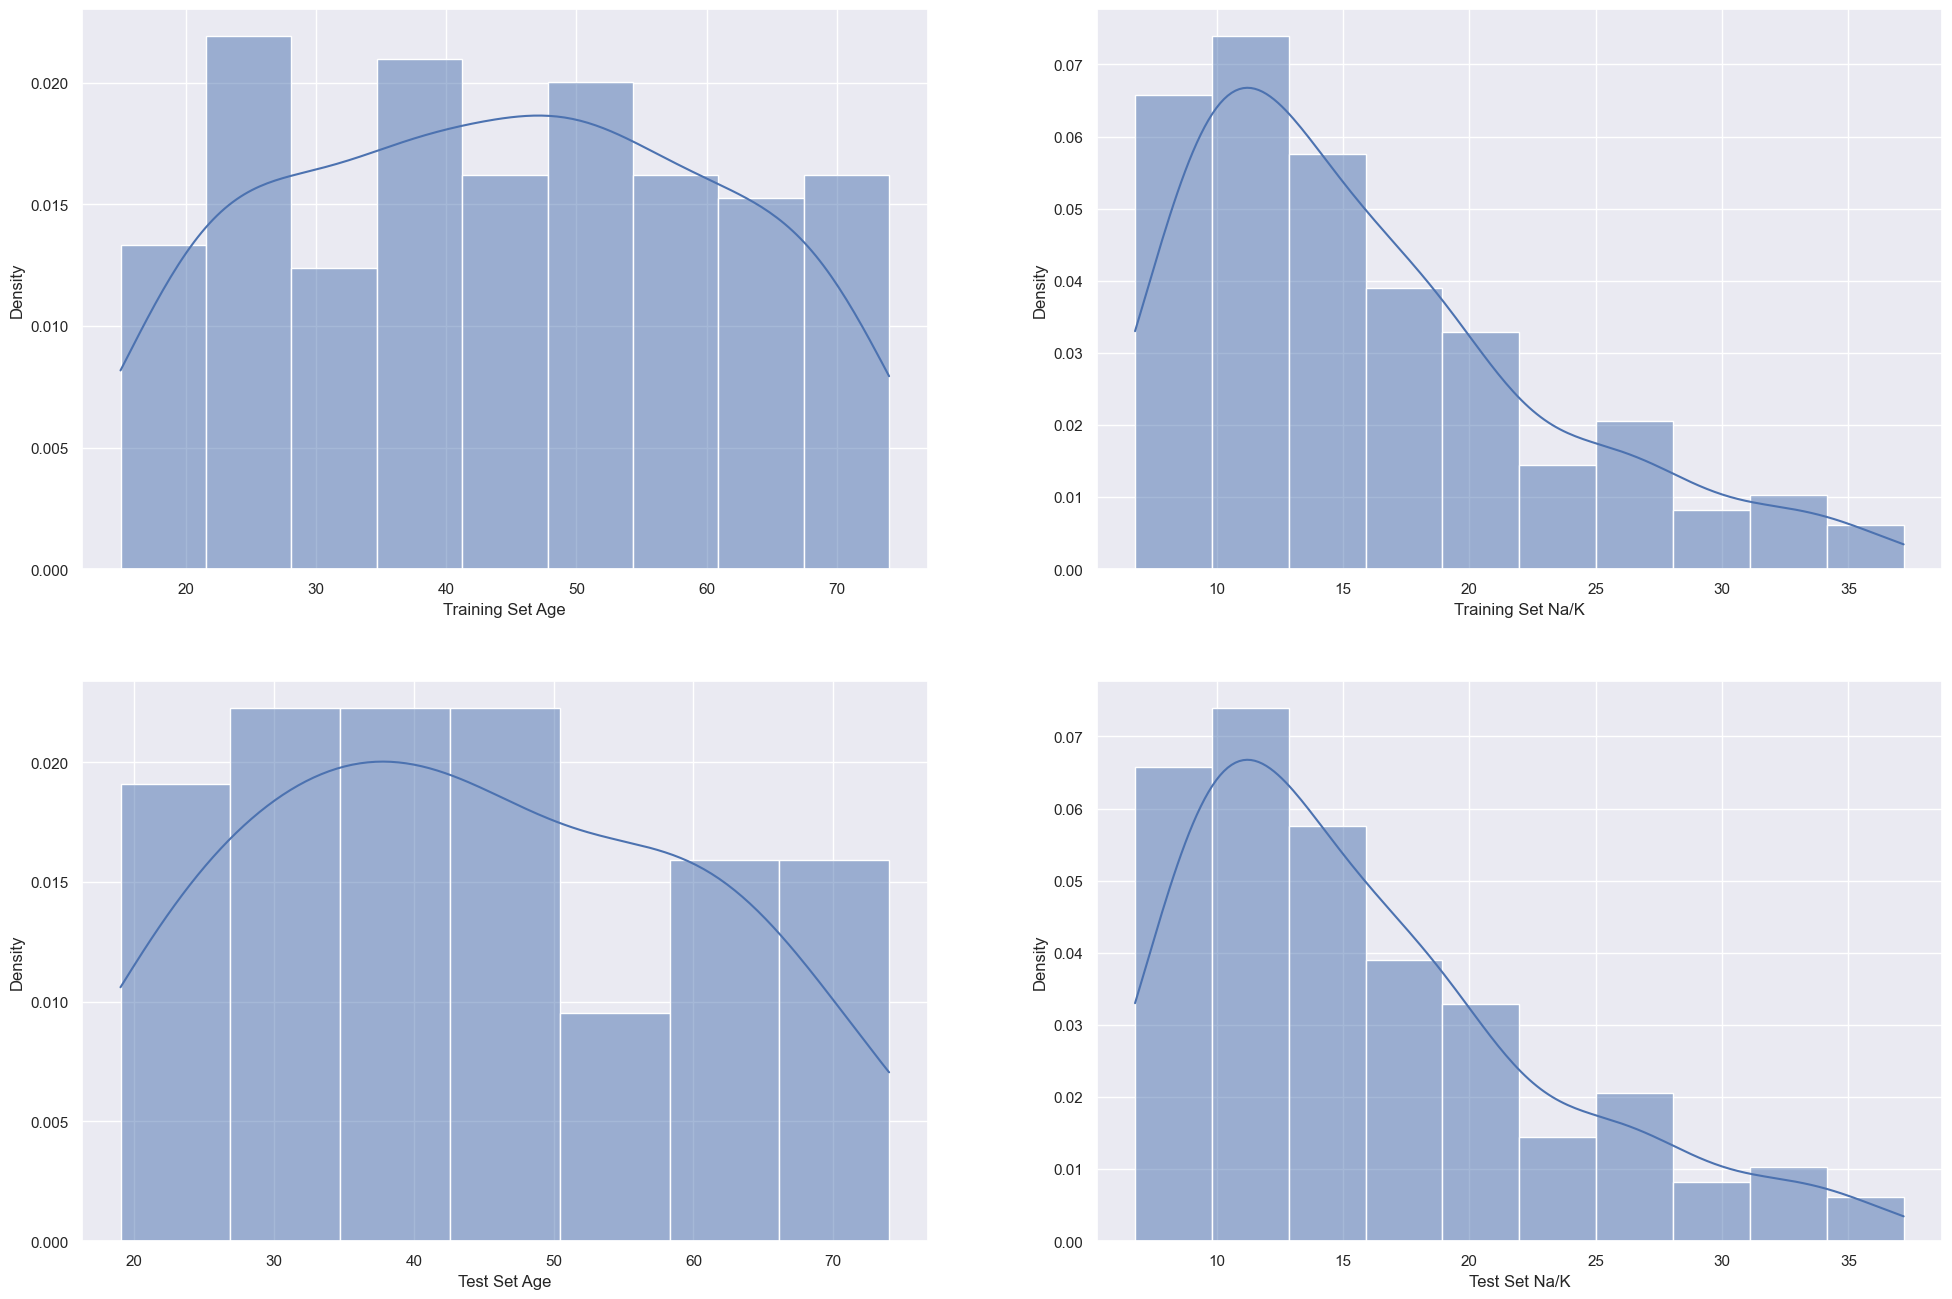

In [13]:
# Let's check the distributions of our two numeric features for our training/test sets

_, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (24, 16))

sns.histplot(data = X_train[:, 0], kde=True, stat = "density", ax = axes[0][0])
sns.histplot(data = X_train[:, 4], kde=True, stat = "density", ax = axes[0][1])
sns.histplot(data = X_test[:, 0], kde=True, stat = "density", ax = axes[1][0])
sns.histplot(data = X_train[:, 4], kde=True, stat = "density", ax = axes[1][1])

axes[0][0].set(xlabel = "Training Set Age")
axes[0][1].set(xlabel = "Training Set Na/K")
axes[1][0].set(xlabel = "Test Set Age")
axes[1][1].set(xlabel = "Test Set Na/K")

In [14]:
# Standardize the numeric features of our training/test sets

ss = StandardScaler()
X_train[:, [0, 4]] = ss.fit_transform(X_train[:, [0, 4]])
X_test[:, [0, 4]] = ss.transform(X_test[:, [0, 4]])

## Nested CV for Algorithm Selection

In [15]:
# Create classifier objects
knn = KNeighborsClassifier(metric = 'minkowski', p = 2)
dec_tree = DecisionTreeClassifier(random_state = 123)
rand_forest = RandomForestClassifier(random_state = 123)
log_reg = LogisticRegression(solver = 'newton-cg', random_state = 123)

# create param grid for GSCV
param_dict = [{'n_neighbors': list(range(1, 11)), 'weights':['uniform', 'distance']},
              {'max_depth': list(range(1, 11)), 'criterion': ['entropy', 'gini'],'splitter': ['best', 'random']},
              {'criterion': ['entropy', 'gini'], 'n_estimators' : list(range(100, 1001, 100))},
              {'C': [1.0, 1.25, 1.5, 1.75, 2.0], 'class_weight': ['balanced', None]}]

classifiers = [knn, dec_tree, rand_forest, log_reg] 
names = ['K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Logistic Regression']

gs_dict = {}

# inner loop: 2-Fold CV
inner_cv = StratifiedKFold(n_splits = 2, 
                           shuffle = True,
                           random_state = 123)

# Create GS objects for each classifier
for clf, params, name in zip(classifiers, param_dict, names):
    gs = GridSearchCV(estimator = clf,
                      cv = inner_cv,
                      param_grid = params,
                      n_jobs = -1,
                      refit = True)
    gs_dict[name] = gs
# create cv object for outer loop
outer_cv = StratifiedKFold(n_splits = 5,
                           shuffle = True,
                           random_state = 123)
# Create the outer loop and train the GS Objects

for name, gs_est in gs_dict.items():
    nested_score = cross_val_score(estimator = gs_est,
                                   X = X_train,
                                   y = y_train,
                                   cv = outer_cv,
                                   scoring = 'balanced_accuracy',
                                   n_jobs = -1)
    print(f"{name} | Balanced Accuracy: {nested_score.mean():.4f} +/- {nested_score.std():.4f}")

K Nearest Neighbors | Balanced Accuracy: 0.8680 +/- 0.0622
Decision Tree | Balanced Accuracy: 0.9956 +/- 0.0089
Random Forest | Balanced Accuracy: 0.9822 +/- 0.0259
Logistic Regression | Balanced Accuracy: 0.9260 +/- 0.0514


## LOOCV for Model Selection with the Decision Tree algorithm

In [16]:
ms_gcv = GridSearchCV(estimator = dec_tree,
                      param_grid = param_dict[1],
                      cv = LeaveOneOut(),
                      verbose = 1,
                      refit = True,
                      n_jobs = -1,
                      scoring = 'balanced_accuracy',
                      )
ms_gcv.fit(X_train, y_train)

Fitting 160 folds for each of 40 candidates, totalling 6400 fits


GridSearchCV(cv=LeaveOneOut(),
             estimator=DecisionTreeClassifier(random_state=123), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'splitter': ['best', 'random']},
             scoring='balanced_accuracy', verbose=1)

In [17]:
print(f"Best Model: {ms_gcv.best_params_}, \t Balanced ACC = {ms_gcv.best_score_*100:.4f}%")

Best Model: {'criterion': 'entropy', 'max_depth': 4, 'splitter': 'best'}, 	 Balanced ACC = 98.1250%


## Test Set predictions and Scoring

In [18]:
y_pred = ms_gcv.predict(X_test)

In [19]:
bal_acc = balanced_accuracy_score(y_true = y_test, y_pred = y_pred)
print(f"Balanced Accuracy = {bal_acc * 100:.2f}%")

f1 = f1_score(y_true = y_test, y_pred = y_pred, average = 'weighted')
print(f"F1 Score = {f1* 100:.2f}%")

pre = precision_score(y_true = y_test, y_pred = y_pred, average = 'weighted')
print(f"Precision Score = {pre * 100:.2f}%")

rec = recall_score(y_true = y_test, y_pred = y_pred, average = 'weighted')
print(f"Recall Score = {rec * 100:.2f}%")

Balanced Accuracy = 100.00%
F1 Score = 100.00%
Precision Score = 100.00%
Recall Score = 100.00%


In [20]:
bs_scores = bootstrap_point632_score(estimator = ms_gcv.best_estimator_,
                                     X = X_train,
                                     y = y_train,
                                     n_splits = 500,
                                     method = '.632+',
                                     random_seed = 123)
print(f"CI = {(np.percentile(bs_scores, 2.5), np.percentile(bs_scores, 97.5))}")
print(f"Mean Score = {np.mean(bs_scores)}")
print(f"Standard Deviation = {np.std(bs_scores)}")

CI = (0.959109746362979, 1.0)
Mean Score = 0.9875537872817354
Standard Deviation = 0.01694733580495214


## Refit the model on the entire dataset

In [21]:
dec_tree_final = DecisionTreeClassifier(criterion = 'entropy', 
                              max_depth = 4,
                              splitter = 'best',
                              random_state = 123)
X[:, [0, 4]] = ss.fit_transform(X[:, [0, 4]])

dec_tree_final.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)

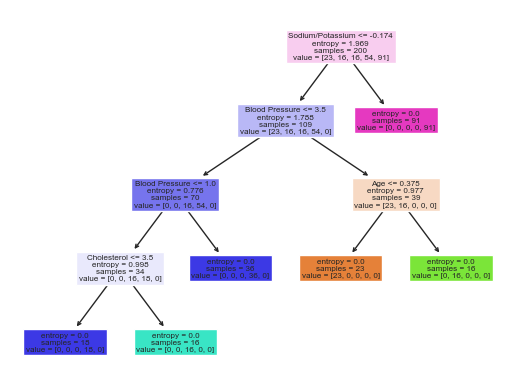

In [24]:
# Plot the final Decision Tree
tree.plot_tree(dec_tree_final,
               feature_names = ['Age', 'Sex', 'Blood Pressure', 'Cholesterol', 'Sodium/Potassium'], 
               filled=True);